In [1]:
import numpy as np
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import metrics

np.random.seed(32)

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
data_path = '/nfs/science-tuk-ins/tesco_insurance/adamho/AppliedMLTraining/data/'
train = pd.read_csv(data_path + 'regression.csv')

In [3]:
train.head()

household  retailer_dollar_sales  retailer_units  dollar_sales  units  \
0        819                   9.86               5          9.86      5   
1        875                   6.53               5          6.53      5   
2       1132                   2.78               5          2.78      5   
3       1230                  17.93               8         15.04      7   
4       2044                  10.74               6         10.74      6   

   store_satisfaction  
0            5.288486  
1            4.876407  
2            4.022451  
3            5.886475  
4            5.373975

## Excercise 4: Feature Selection and Regularisation

So far, we've been trying out models with differing amounts of polynomial features. However, what if there is no easy way to decide which features to keep and which ones to drop? Or what happens when the dataset has so many features that it would take *forever* to drop individual features by hand?

We need some smart ways of adding/removing features from our model.

We'll take our 'regression.csv' dataset. However - rather than generating polynomial features for the 'units' variable - we'll stick in all of the features in the dataset and generate some polynomials for all of them.

We'll then use three different feature selection methods and test 1) how long they take 2) how well our model performs at the end:

1. Univariate Selection
2. Recursive Selection
3. Regularisation

In [4]:
X = train[['retailer_dollar_sales','retailer_units', 'dollar_sales', 'units']]
y = train['store_satisfaction']

In [5]:
# First, let's prepare our dataset by splitting it in to a train and two test sets
training_X, testing_X, training_Y, testing_Y = train_test_split(X, y, test_size=0.3)
test_X, eval_X, test_Y, eval_Y = train_test_split(testing_X, testing_Y, test_size=0.5)

In [6]:
# Use the PolynomialFeatures class in sklearn to calculate polynomial features of training_X up to degree 4
degree = 4
poly = preprocessing.PolynomialFeatures(degree=degree, include_bias=False)
training_X_poly = poly.fit_transform(training_X)
test_X_poly = poly.transform(test_X)
eval_X_poly = poly.transform(eval_X)

In [7]:
print ('We now have {0:d} features in our dataset') .format(training_X_poly.shape[1])

We now have 69 features in our dataset


In [8]:
# Let's now scale our data using the MinMaxScaler
scl = preprocessing.MinMaxScaler()
training_X_poly = scl.fit_transform(training_X_poly)
test_X_poly = scl.transform(test_X_poly)
eval_X_poly = scl.transform(eval_X_poly)

In [9]:
# Let's also calculate model performance when all variables are included (e.g. prior to feature selection)
mod = linear_model.LinearRegression()
mod.fit(training_X_poly, training_Y)
preds = mod.predict(test_X_poly)

RMSE_bmrk = np.sqrt(metrics.mean_squared_error(test_Y, preds))
R2_bmrk = metrics.r2_score(test_Y, preds)
print('The benchmark RMSE (i.e. no feature selection) on the test set is {0:.2f} ') .format(RMSE_bmrk)

The benchmark RMSE (i.e. no feature selection) on the test set is 4.24 


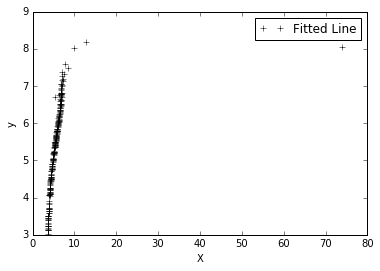

In [12]:
# Plot a black line showing the y against the predictions
plt.plot(preds, test_Y, '+k',
         linewidth=3, label='Fitted Line'); 
plt.legend()
plt.xlabel('X');
plt.ylabel('y');

## Excercise 4.2: Univariate Selection

Let's see what univariate feature selection leaves us with when we apply it to the training set...

In [13]:
# Select the best k variables, according to the f_regression function
k = 10

from sklearn.feature_selection import f_regression, SelectKBest
slctr = SelectKBest(f_regression, k=k)
training_uni_select = slctr.fit_transform(training_X_poly, training_Y)

# Keep only the useful variables in the test set
testing_uni_select = slctr.transform(test_X_poly)

# Print the results of the KBest feature selection
print 'The KBest feature selection method selected {0:d} variables' .format(training_uni_select.shape[1])

The KBest feature selection method selected 10 variables


In [14]:
# Fit model and make predictions
mod.fit(training_uni_select, training_Y)
preds = mod.predict(testing_uni_select)

In [15]:
# Now let's evaluate our model performance
RMSE_kbest = np.sqrt(metrics.mean_squared_error(test_Y, preds))
R2_kbest = metrics.r2_score(test_Y, preds)
print('The RMSE for this model on the test set is {0:.2f} ') .format(RMSE_kbest)

The RMSE for this model on the test set is 0.67 


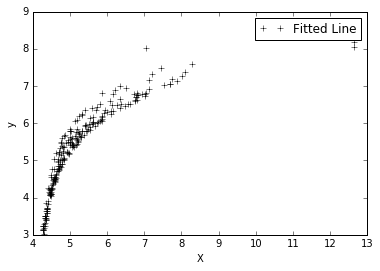

In [16]:
# Plot a black line showing the y against the predictions
plt.plot(preds, test_Y, '+k',
         linewidth=3, label='Fitted Line'); 
plt.legend()
plt.xlabel('X');
plt.ylabel('y');

The performance is significantly better than the benchmark RMSE. It's jumped from 1.71 to 0.53. That's very promising! Now let's see what happens when we try recursive selection...

## Excercise 4.3: Recursive Feature Selection

With recursive feature selection, we build models using subsets of data. We then test whether they're useful using cross-validation.


In [17]:
# Recursively select the best features in a linear regression model
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=linear_model.LinearRegression(), step=1, cv=10,
              scoring='mean_squared_error')
training_X_recur = rfecv.fit_transform(training_X_poly, training_Y)

# Keep only useful features in test set
testing_X_recur = rfecv.transform(test_X_poly)

# Print the results of the KBest feature selection
print 'The RFECV feature selection method selected {0:d} variables' .format(training_X_recur.shape[1])

The RFECV feature selection method selected 4 variables


In [18]:
# Fit model and make predictions
mod.fit(training_X_recur, training_Y)
preds = mod.predict(testing_X_recur)

In [19]:
# Now lets test how well the model performs
RMSE_recur = np.sqrt(metrics.mean_squared_error(test_Y, preds))
R2_recur = metrics.r2_score(test_Y, preds)
print('The RMSE for this model on the test set is {0:.2f} ') .format(RMSE_recur)

The RMSE for this model on the test set is 1.13 


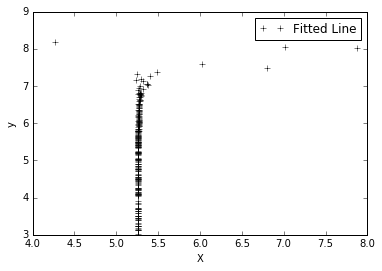

In [20]:
# Plot the predictions against the target
plt.plot(preds, test_Y, '+k',
         linewidth=3, label='Fitted Line'); 
plt.legend()
plt.xlabel('X');
plt.ylabel('y');

RFECV doesn't seem to have given us as good results as the univariate selection. You can see why when you look at the plot; the predictions appear to be restricted to around 5.3.

## Excercise 4.4: L1 Regularised Regression (a.k.a. Lasso)

Regularised regression is a method that attempts to select the best features analytically. This compares to the other approaches, which use the results of model fits to assess whether features should be kept or not.

The mathematics of L1 regularised regression are beyond the scope of this course. We strongly recommend the Introduction to Statistical Learning book (Hastie et al.) if you want to know more.

To briefly summarise, L1 will try to 'shrink' out features that aren't useful or highly correlated with other features in your model. It does this by looking at the $\theta$ values of your model.

To control the level of shrinkage, you need to 'tune' the $\alpha$ hyperparameter (this is often called 'alpha' or the 'shrinkage parameter'). Therefore, you need to perform a grid-search over different alpha values to find the one that maximises the cross-validation performance

In [21]:
from sklearn import grid_search
parameters = {'alpha':[0.0001, 0.001,0.01,0.1]} # The 'C' parameter is the regularisation lambda
mod = linear_model.Lasso()
clf = grid_search.GridSearchCV(mod, parameters, cv=5, n_jobs=1)
clf.fit(training_X_poly, training_Y) # This performs a grid search across all listed values for C
# Now we can make predictions with the best model from the grid search
preds = clf.predict(test_X_poly)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [22]:
# Now lets test how well the model performs
RMSE_lasso = np.sqrt(metrics.mean_squared_error(test_Y, preds))
print('The RMSE for this model on the test set is {0:.2f} ') .format(RMSE_lasso)
print('The best performing alpha value was {0:s}') .format(clf.best_params_ )
print('The best performing model kept {0:d} features') .format(np.count_nonzero(clf.best_estimator_.coef_))

The RMSE for this model on the test set is 0.57 
The best performing alpha value was {'alpha': 0.001}
The best performing model kept 7 features


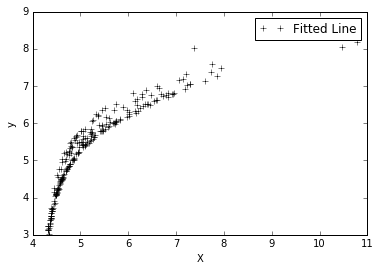

In [23]:
# Plot the predictions against the target
plt.plot(preds, test_Y, '+k',
         linewidth=3, label='Fitted Line'); 
plt.legend()
plt.xlabel('X');
plt.ylabel('y');

We can also inspect the full regression equation of the best performing model by calling the .coef_ method

In [24]:
coefs = clf.best_estimator_.coef_

In [25]:
equation = str(clf.best_estimator_.intercept_) + ' + '.join(['X' + str(y) + ' * ' + str(x) + '' for x,y in zip(coefs, range(0,len(coefs))) if x > 0])
print 'The final equation of the best Lasso regression model is :\nPred =  {0:s}' .format(equation)

The final equation of the best Lasso regression model is :
Pred =  4.28951871744X0 * 17.868681724 + X1 * 3.32104230575 + X2 * 6.72094662852 + X64 * 4.01851365747


So there we have it! Lasso regression gave us the best performing model, and all it took was a few lines of code and a quick grid search over a couple of different values of $\alpha$. 

The final model was considerably better than one that had no feature selection and we now have a simple equation that uses only four variables.

Personally, I think that this highlights the value of regularised regression. I would almost always start all modelling problems by running a regularised regression through the data and grid searching over various values of the shrinkage parameter. This - combined with polynomial features and interaction terms - can often generate state-of-the-art results, and you have a nice equation at the end to show your client.